# Two Moons Conditional

Let's test our standard normalizing flow with the Two Moons.

We want to condition on the left/right moon.

In [1]:
import __init__

SEED = 0xdeadc0de

In [2]:
from calas.tools.two_moons import two_moons_likelihood, two_moons_rejection_sampling
from torch import device

dev = device('cuda:0')
samples = two_moons_rejection_sampling(nsamples=50_000, seed=SEED).to(dev)

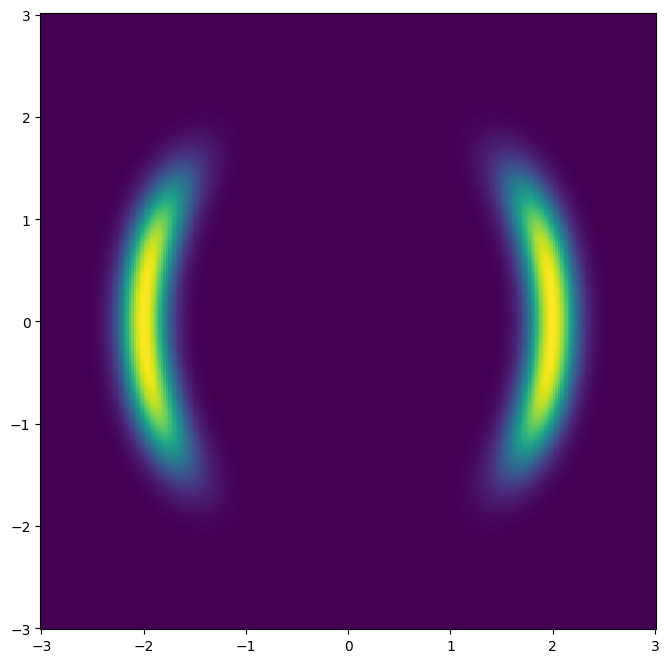

In [3]:
import torch
from matplotlib import pyplot as plt


grid_size = 250
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size), indexing='ij')
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(dev)

exp_probs = two_moons_likelihood(input=zz)
p_target = exp_probs.view(*xx.shape).cpu().data.numpy()

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, p_target, shading='auto')
plt.gca().set_aspect('equal', 'box')
plt.show()

In [4]:
from torch import nn, Tensor
from calas.models.flow import CalasFlow
from normflows.flows import Flow, AutoregressiveRationalQuadraticSpline, LULinearPermute

torch.manual_seed(0)

K = 16
latent_size = 2
hidden_units = 32
hidden_layers = 2

flows = []
for i in range(K):
    flows += [AutoregressiveRationalQuadraticSpline(
        num_input_channels=latent_size, num_blocks=hidden_layers,
        num_hidden_channels=hidden_units, num_context_channels=2*latent_size,
        dropout_probability=0.1, permute_mask=True, activation=nn.SiLU)]
    flows += [LULinearPermute(latent_size)]


flow = CalasFlow(num_dims=2, num_classes=2, dev=dev, flows=flows).to(device=dev)


# class Dummy(nn.Module):
#     def __init__(self, flow: CalasFlow, *args, **kwargs):
#         super().__init__(*args, **kwargs)

#         self.model = nn.Sequential(
#             nn.Linear(in_features=2, out_features=8, bias=True, device=flow.dev),
#             nn.Dropout1d(p=0.2),
#             nn.SiLU(),
#             nn.Linear(in_features=8, out_features=4, bias=True, device=flow.dev))
        
#         self.flow = flow
    
#     def forward(self, x: Tensor, classes: Tensor) -> Tensor:
#         x = self.model(x)
#         return self.flow.loss(x=x, classes=classes)


# model = Dummy(flow=flow).to(device=dev)

Now we will create conditions/classes, where all data on the left is in class A and all other data is in class B.

In [5]:
sample_classes = torch.where(samples[:, 0] < 0, 0, 1)

# Training

In [6]:
from tqdm import tqdm
import numpy as np

BATCH_SIZE = 3_000
EPOCHS = 160


losses: list[float] = []
optim = torch.optim.Adam(flow.parameters(), lr=1e-5, weight_decay=1e-6)

with tqdm(iterable=range(EPOCHS), total=EPOCHS, desc='Training', ncols=80) as progress:
    epoch = 0
    while epoch < EPOCHS:
        perm = torch.randperm(samples.shape[0], device=dev)

        data = samples[perm[0:BATCH_SIZE]]
        classes = sample_classes[perm[0:BATCH_SIZE]]
        
        loss = flow.loss(x=data, classes=classes)
        # loss = model.forward(x=data_batch, classes=classes_batch)
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optim.step()
            losses.append(loss.item())
            progress.set_description(f'Loss: {losses[-1]:.4f}')
            progress.update()
            epoch += 1

Loss: 3.7313: 100%|███████████████████████████| 160/160 [02:22<00:00,  1.12it/s]


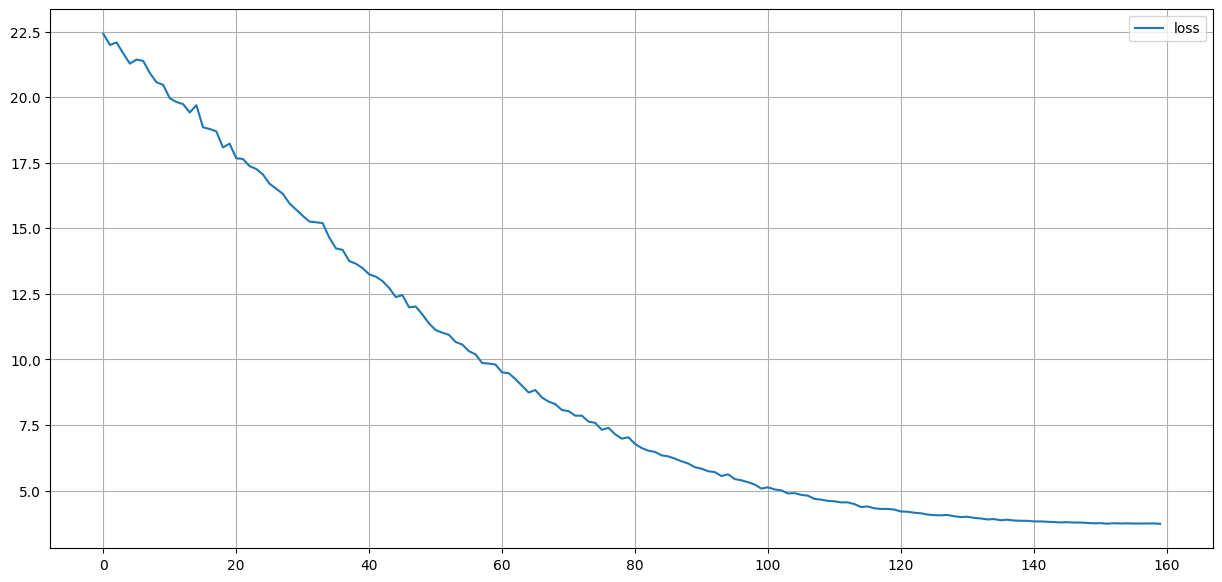

In [7]:
# Plot loss
plt.figure(figsize=(15, 7))
plt.plot(np.array(losses), label='loss')
plt.legend()
plt.grid()
plt.show()

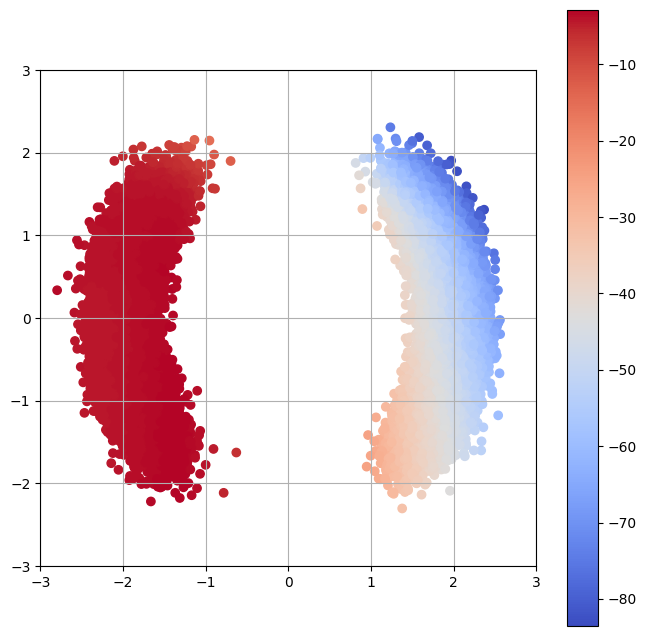

In [36]:
# def log_prob(s: Tensor, c: Tensor) -> Tensor:
#     s = model.model(s)
#     return flow.log_prob(x=s, classes=c)

samples_np = samples.cpu().numpy()
xx, yy = torch.meshgrid(samples[:, 0], samples[:, 1], indexing='ij')
likelihood = flow.log_prob(x=samples, classes=torch.zeros(samples.shape[0], device=samples.device)) # sample_classes
# likelihood = log_prob(s=samples, c=torch.zeros(samples.shape[0], device=samples.device))

plt.figure(figsize=(8, 8))
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.scatter(samples_np[:, 0], samples_np[:, 1], c=likelihood.detach().cpu().numpy(), cmap='coolwarm')#, vmin=likelihood.mean().item())
plt.gca().set_aspect('equal', 'box')
plt.grid(visible=True)
plt.colorbar()
plt.show()

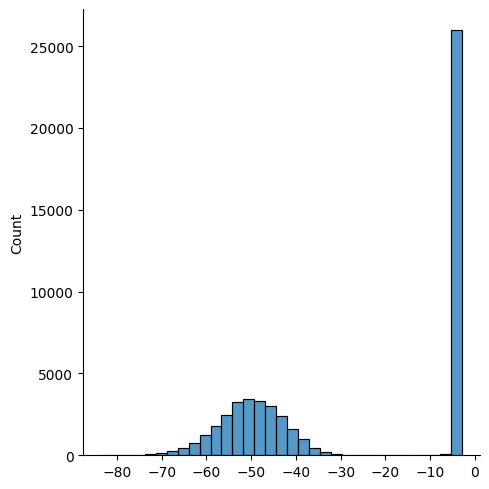

In [37]:
sns.displot(likelihood.detach().cpu().numpy())

(-5.0, -2.8)

<Figure size 640x480 with 0 Axes>

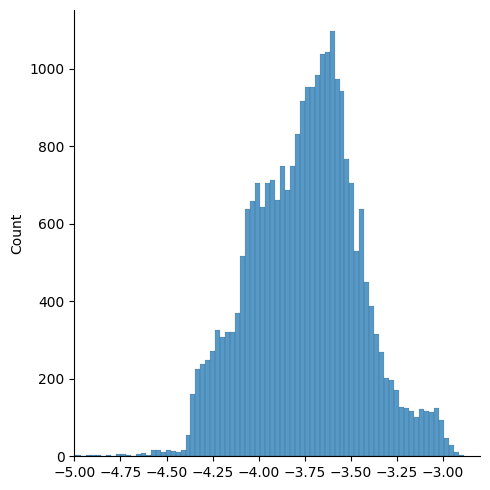

In [41]:
plt.clf()
sns.displot(flow.log_prob(x=samples_left, classes=torch.zeros(samples_left.shape[0], device=dev)).detach().cpu().numpy())
plt.xlim(-5, -2.8)

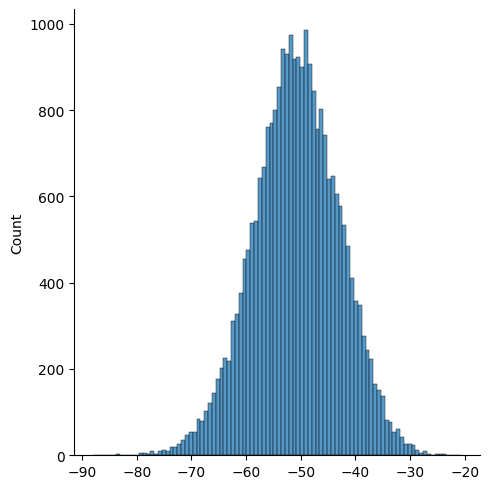

In [39]:
sns.displot(flow.log_prob(x=samples_left, classes=torch.ones(samples_left.shape[0], device=dev)).detach().cpu().numpy())

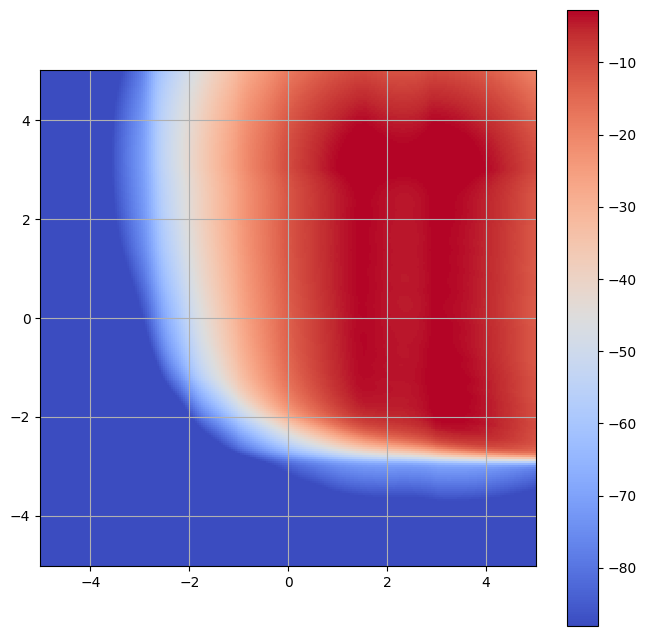

In [33]:
grid_size = 250
xx, yy = torch.meshgrid(torch.linspace(-5, 5, grid_size), torch.linspace(-5, 5, grid_size), indexing='ij')
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(dev)

# exp_probs = log_prob(s=zz, c=torch.zeros(zz.shape[0], device=zz.device))
exp_probs = flow.log_prob(x=zz, classes=torch.zeros(zz.shape[0], device=zz.device))
p_target = exp_probs.view(*xx.shape).cpu().data.numpy()

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, p_target, shading='auto', cmap='coolwarm', vmin=likelihood.min().item(), vmax=likelihood.max().item())
plt.gca().set_aspect('equal', 'box')
plt.grid(visible=True)
plt.colorbar()
plt.show()

In [10]:
samples_left = samples[samples[:, 0] < 0]
samples_right = samples[samples[:, 0] >= 0]

# These are correctly forwarded, i.e., the classes match!
b_left = flow.x_to_b(x=samples_left, classes=torch.zeros(samples_left.shape[0], device=samples_left.device))[0]
b_right = flow.x_to_b(x=samples_right, classes=torch.ones(samples_right.shape[0], device=samples_right.device))[0]

# Same, but mixed-up classes!
b_left_wrong = flow.x_to_b(x=samples_left, classes=torch.ones(samples_left.shape[0], device=samples_left.device))[0]
b_right_wrong = flow.x_to_b(x=samples_right, classes=torch.zeros(samples_right.shape[0], device=samples_right.device))[0]

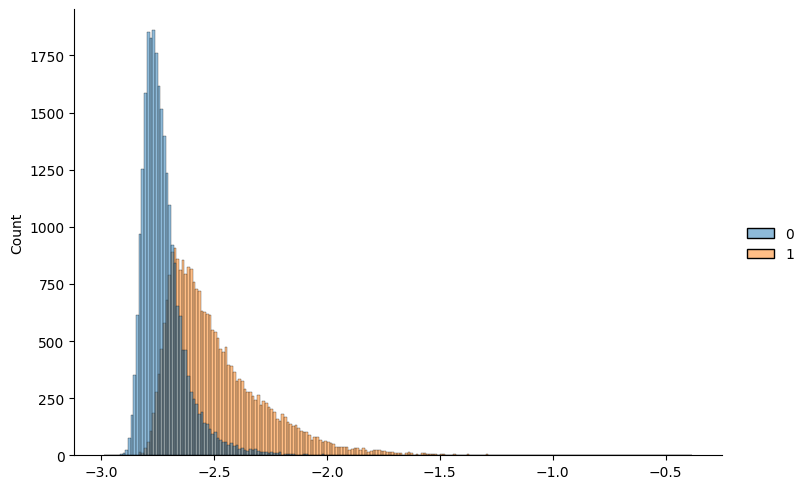

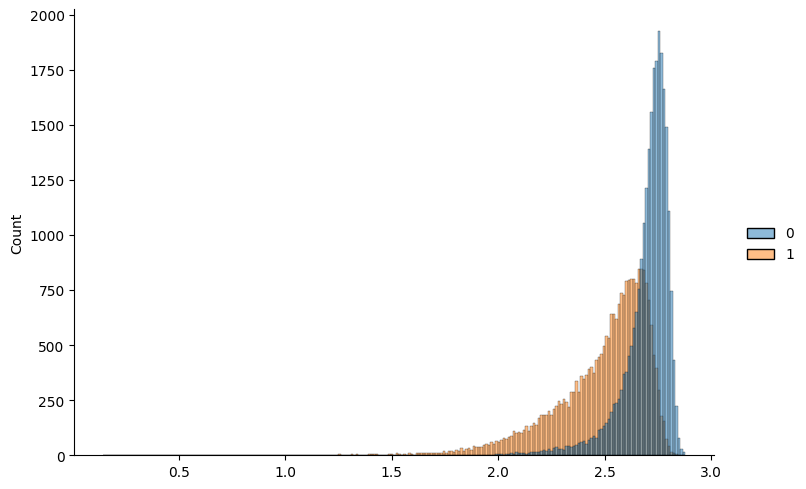

In [26]:
import seaborn as sns

aspect = 1.5
sns.displot(b_left.detach().cpu().numpy(), aspect=aspect)
sns.displot(b_right.detach().cpu().numpy(), aspect=aspect)

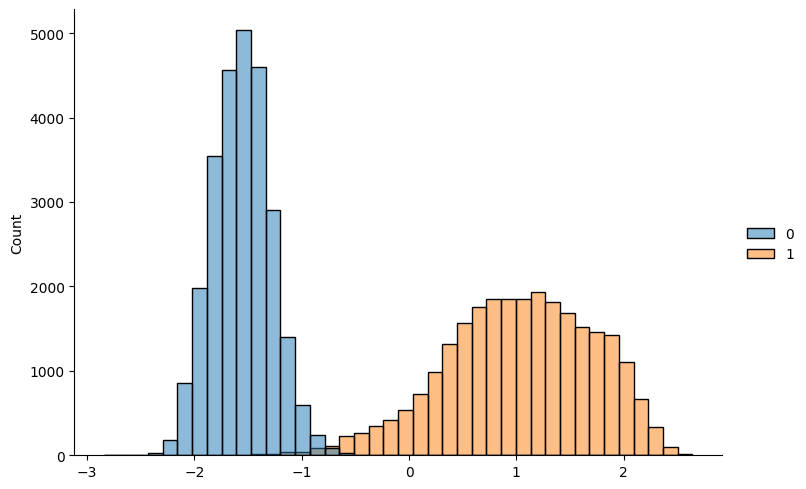

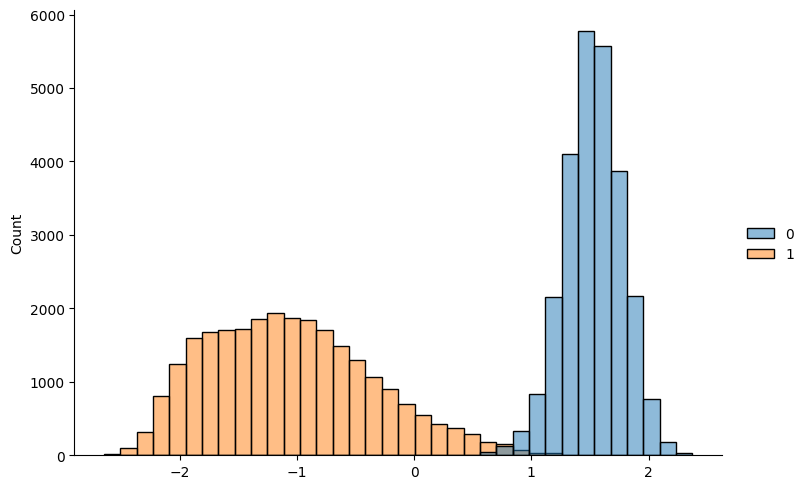

In [25]:
sns.displot(b_left_wrong.detach().cpu().numpy(), aspect=aspect)
sns.displot(b_right_wrong.detach().cpu().numpy(), aspect=aspect)